We need to make sure the point is clear that the purpose is to find optimal methods with minimal data. "I dont have enough data" is not an excuse.


Make sure we are using the same 32 data points for all the models.

In [1]:
!pip install datasets transformers==4.37.2 openai

zsh:1: command not found: pip


In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings
from transformers import pipeline
from itertools import combinations
from collections import Counter, defaultdict
from datasets import load_dataset
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam

from spacy.matcher import Matcher
import spacy
import nltk
import re
import plotly.express as px
from transformers import AutoTokenizer, TFAutoModel

from wordcloud import WordCloud

# Additional setup
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

import numpy as np
import pandas as pd
from transformers import BertTokenizer

import json
import os
import time

import pandas as pd
from openai import OpenAI
import seaborn as sns
from tenacity import retry, wait_exponential
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()
from openai import OpenAI



/Users/andrewbennett/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewbennett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

### Load Data



In [3]:
dataset = load_dataset("super_glue", 'boolq')


In [4]:
# turn dataset into pandas dataframe
train = pd.DataFrame(dataset['train'])
val = pd.DataFrame(dataset['validation'])
test = pd.DataFrame(dataset['test'])



In [5]:
train.head()

,question,passage,idx,label
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",0,1
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,1,1
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,2,1
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",3,1
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,4,0


note the validation set is used for training and validation. The test set does not have valid labels, because it is used to submit to the leaderboard.

In [6]:
# merge premise and hypothesis into one column
train['all_text'] = train['question'] + ' ' + train['passage']
test['all_text'] = test['question'] + ' ' + test['passage']
val['all_text'] = val['question'] + ' ' + val['passage']

### Rule Based Classifier 

In [17]:
for each, row in train.loc[train.label == 1][:10].iterrows():
    print(row.question)
    print(row.passage)

do iran and afghanistan speak the same language
Persian language -- Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.
do good samaritan laws protect those who help at an accident
Good Samaritan law -- Good Samaritan laws offer legal protection to people who give reasonable assistance to those who are, or who they believe to be, injured, ill, in peril, or otherwise incapacitated. The protection is intended to reduce bystanders' hesitation to assist, for fear o

In [18]:
for each, row in train.loc[train.label == 0][:10].iterrows():
    print(row.question)
    print(row.passage)

is elder scrolls online the same as skyrim
The Elder Scrolls Online -- As with other games in The Elder Scrolls series, the game is set on the continent of Tamriel. The events of the game occur a millennium before those of The Elder Scrolls V: Skyrim and around 800 years before The Elder Scrolls III: Morrowind and The Elder Scrolls IV: Oblivion. It has a broadly similar structure to Skyrim, with two separate conflicts progressing at the same time, one with the fate of the world in the balance, and one where the prize is supreme power on Tamriel. In The Elder Scrolls Online, the first struggle is against the Daedric Prince Molag Bal, who is attempting to meld the plane of Mundus with his realm of Coldharbour, and the second is to capture the vacant imperial throne, contested by three alliances of the mortal races. The player character has been sacrificed to Molag Bal, and Molag Bal has stolen their soul, the recovery of which is the primary game objective.
can you use oyster card at eps

In [26]:
import spacy 
nlp = spacy.load("en_core_web_sm")

#The idea is that there should be negation terms such as "This is NOT the answer" in the passage. 

# here we determine a set of rules to determine if a sentence is a question

# remove all stopwords with spacy 
val['question_cleaned'] = val.apply(lambda x: nlp(x['question']), axis=1)
val['passage_cleaned'] = val.apply(lambda x: nlp(x['passage']), axis=1)


# remove stop words
val['question_cleaned'] = val.apply(lambda x: [word for word in x['question_cleaned'] if not word.is_stop], axis=1)
val['passage_cleaned'] = val.apply(lambda x: [word for word in x['passage_cleaned'] if not word.is_stop], axis=1)

# remove all words that are in the question from the passage
val['passage_cleaned'] = val.apply(lambda x: [word for word in x['passage_cleaned'] if word not in x['question_cleaned']], axis=1)


In [39]:

# read in negation terms from file 
with open('negation_words.txt', 'r') as f:
    negation_terms = f.read().split('\n')

# lower case negation terms 
negation_terms = [term.lower() for term in negation_terms]

# we will then count the negation terms 
val['negation_count'] = val.apply(lambda x: len([word for word in x['passage_cleaned'] if word.text in negation_terms]), axis=1)

# count how many words from question are in the passage 
val['word_overlap'] = val.apply(lambda x: len([word for word in x['question_cleaned'] if word in x['passage_cleaned']]), axis=1)

# count how many words are in the question 
val['question_word_count'] = val.apply(lambda x: len(x['question_cleaned']), axis=1)

# calculate the difference between the number of words in the question and the overlap
val['word_diff'] = val['question_word_count'] - val['word_overlap']

(array([6.000e+00, 1.370e+02, 6.520e+02, 1.342e+03, 8.390e+02, 2.370e+02,
        4.500e+01, 9.000e+00, 2.000e+00, 1.000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

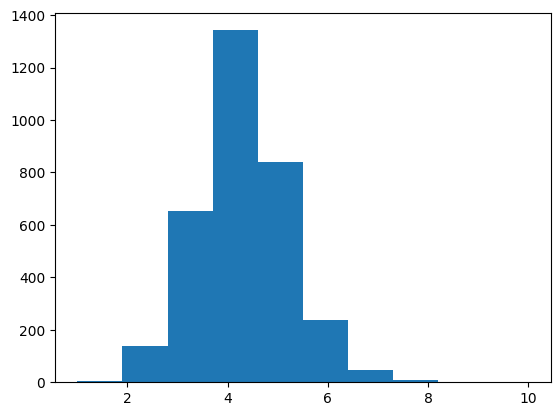

In [41]:

# plot word diff
plt.hist(val['word_diff'])

Let's just split this down the middle and see what happens

In [35]:
# create a label based on if the word_diff is above or below the mean 


val['pred_label'] = val['word_diff'] > val['word_diff'].mean()
val['pred_label'] = val['pred_label'].astype(int)

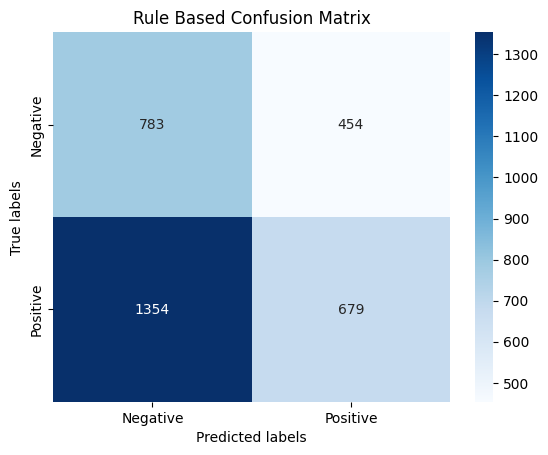

In [36]:


cm = confusion_matrix(val.label, val['pred_label'])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Rule Based Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()



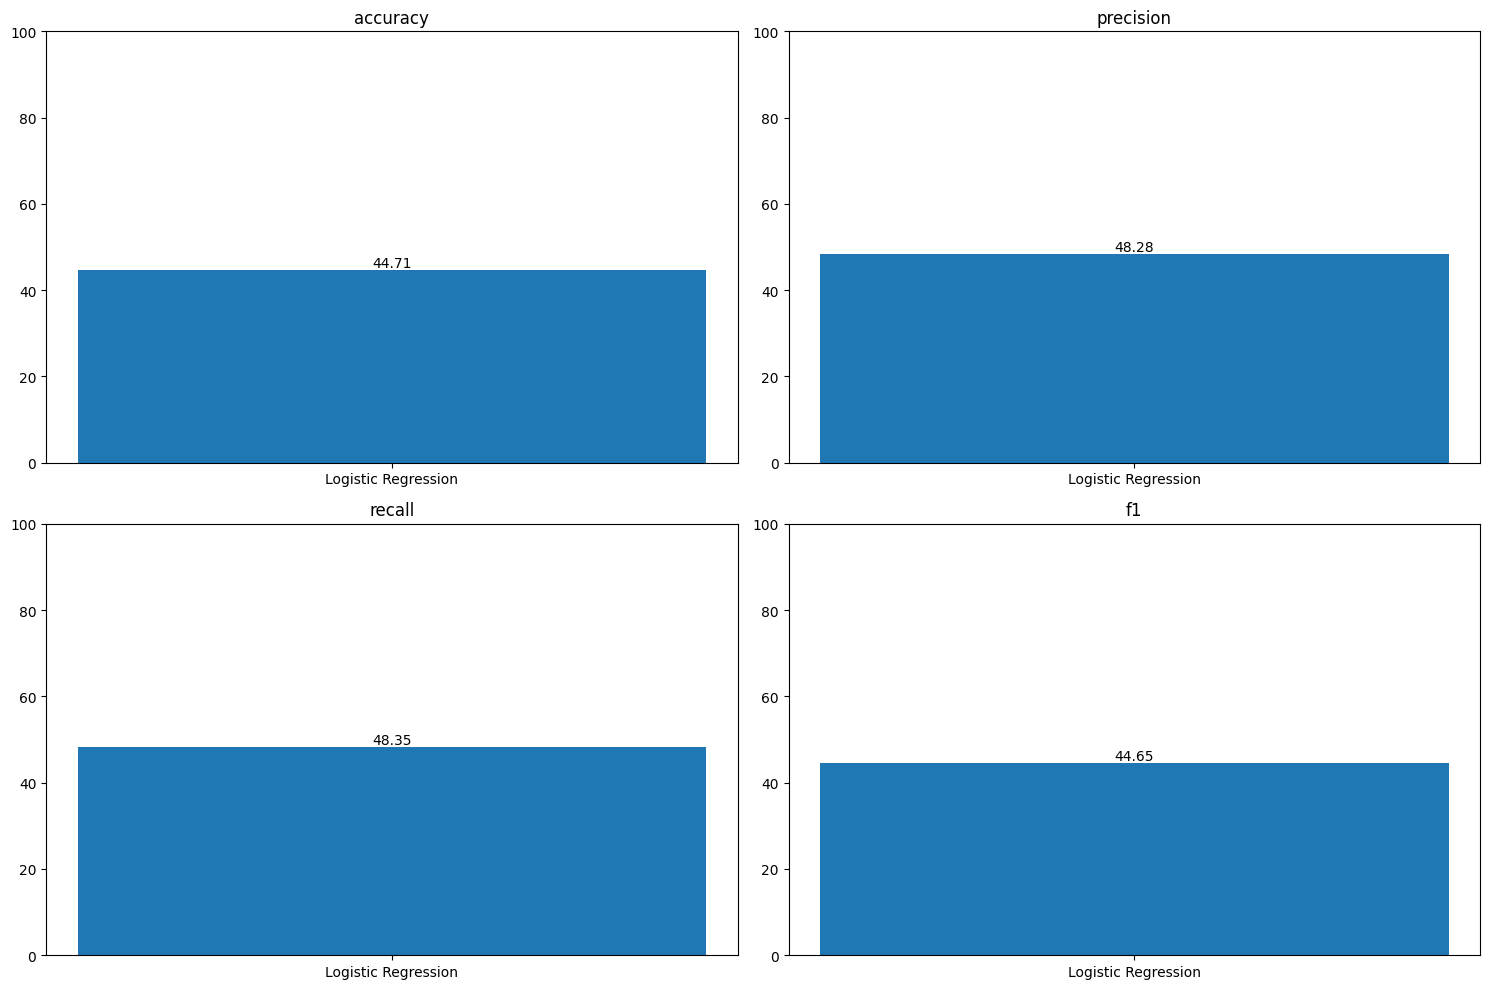

In [38]:

metrics = Metrics()
metrics.run(val.label, val['pred_label'], 'Logistic Regression')
metrics.plot()